In [1]:
# Checking the environment
import sys
import cv2
import numpy as np

![](../images/corners.png)
![](../images/harris.png)

### Implementing Harris Corner Detection from Scratch

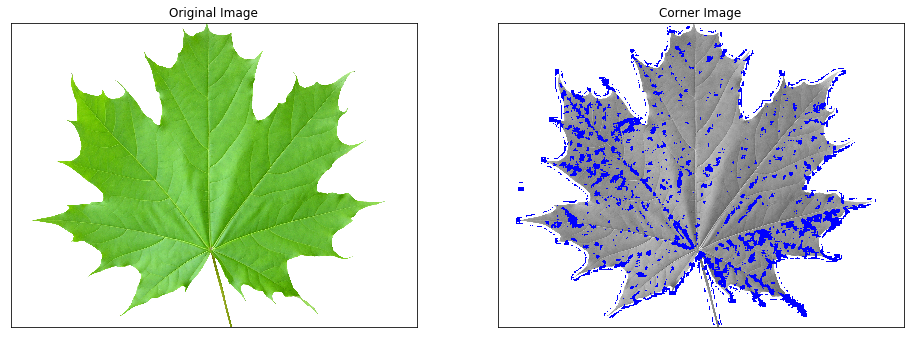

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams['figure.figsize']=(16,8)

def findCorners(img, window_size=5, k=0.04, thresh=10000):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    
    #Find x and y derivatives
    dy, dx = np.gradient(img)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = img.shape[0]
    width = img.shape[1]
    
    newImg = img.copy()
    color_img = cv2.cvtColor(newImg, cv2.COLOR_GRAY2RGB)
    offset = int(window_size/2)

    #Loop through image and find the corners
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            R = det - k*(trace**2)

            #If corner response is over threshold, color the point
            if R > thresh:
                color_img.itemset((y, x, 0), 0)
                color_img.itemset((y, x, 1), 0)
                color_img.itemset((y, x, 2), 255)
    return color_img

IMG = os.path.join("../","images","newleaf.jpg")

img = mpimg.imread(IMG)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

res = findCorners(gray, 20, 0.2, 10000)

plt.subplot(121)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.subplot(122)
plt.title("Corner Image")
plt.xticks([]), plt.yticks([])
plt.imshow(res)

plt.show()

### Corner Detection using Harris-Shi-Tomasi Feature Detector 

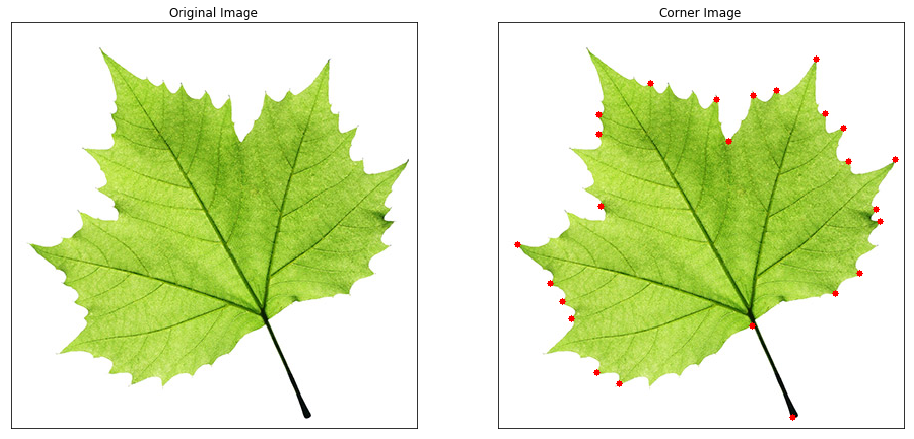

In [13]:
img = mpimg.imread(IMG)
copy = img.copy()

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(copy,(x,y),3,255,-1)


plt.subplot(121)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.subplot(122)
plt.title("Corner Image")
plt.xticks([]), plt.yticks([])
plt.imshow(copy)

plt.show()

### Harris Corner Detection using OpenCV

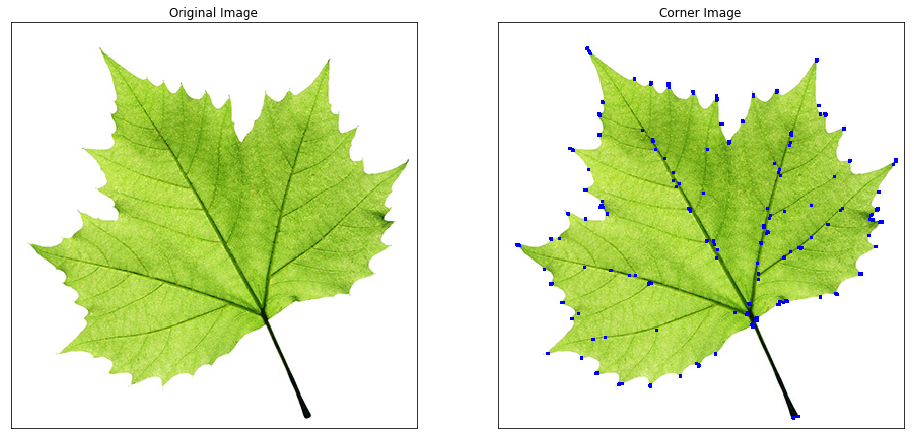

In [14]:
# using cv2.cornerHarris()  

img = mpimg.imread(IMG)
copy = img.copy()

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
copy[dst>0.01*dst.max()]=[0,0,255]

plt.subplot(121)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.subplot(122)
plt.title("Corner Image")
plt.xticks([]), plt.yticks([])
plt.imshow(copy)

plt.show()

### Harris Corner Detection using OpenCV with Sub-Pixel Accuracy

![](../images/corner2.png)

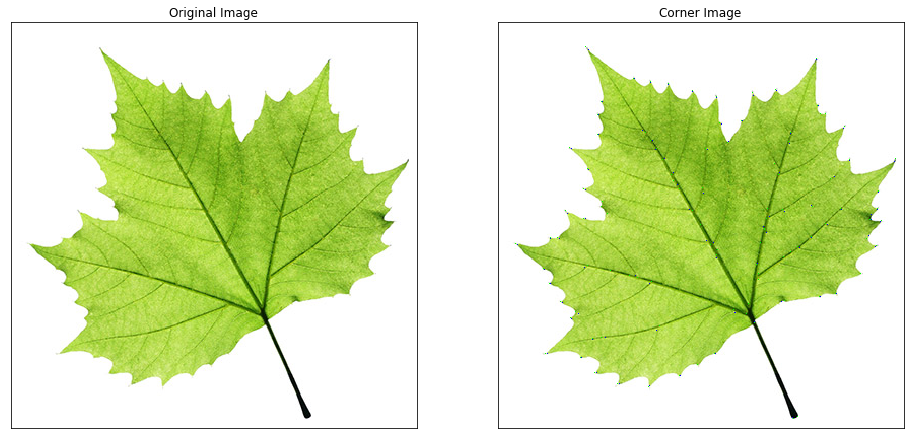

In [15]:
# using cv2.cornerSubPix()  & cv2.connectedComponentsWithStats

IMG = os.path.join("../","images","leaf.jpg")
img = mpimg.imread(IMG)
copy = img.copy()

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw:
# the blue points are really small use cv2.circle to make them visible
res = np.hstack((centroids,corners))
res = np.int0(res)

# assign the transformation to copy image
copy[res[:,1],res[:,0]]=[0,0,255]
copy[res[:,3],res[:,2]] = [0,255,0]



plt.subplot(121)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.subplot(122)
plt.title("Corner Image")
plt.xticks([]), plt.yticks([])
plt.imshow(copy)

plt.show()

### FAST - Features from Accelerated Segment Test

In [13]:
IMG = os.path.join("../","images","newleaf.jpg")
img = mpimg.imread(IMG)

# Initiate FAST object with default values
fast = cv2.FastFeatureDetector_create()

# find and draw the keypoints
kp = fast.detect(img,None)

img2 = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Print all default params
print("Threshold: ", fast.getThreshold())
print("nonmaxSuppression: ", fast.getNonmaxSuppression())
print("neighborhood: ", fast.getType())
print("Total Keypoints with nonmaxSuppression: ", len(kp))


Threshold:  10
nonmaxSuppression:  True
neighborhood:  2
Total Keypoints with nonmaxSuppression:  7888


Total Keypoints without nonmaxSuppression:  17513


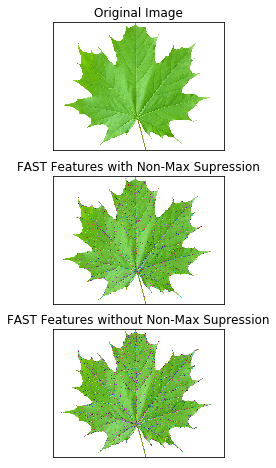

In [15]:
plt.rcParams['figure.figsize']=(16,16)

# Disable nonmaxSuppression
fast.setNonmaxSuppression(0)
kp = fast.detect(img,None)
print("Total Keypoints without nonmaxSuppression: ", len(kp))

img3 = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure("FAST Features",figsize=(8,8))

plt.subplot(311)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.subplot(312)
plt.title("FAST Features with Non-Max Supression")
plt.xticks([]), plt.yticks([])
plt.imshow(img2)

plt.subplot(313)
plt.title("FAST Features without Non-Max Supression")
plt.xticks([]), plt.yticks([])
plt.imshow(img3)

plt.show()

### ORB - Oriented FAST and Rotated BRIEF

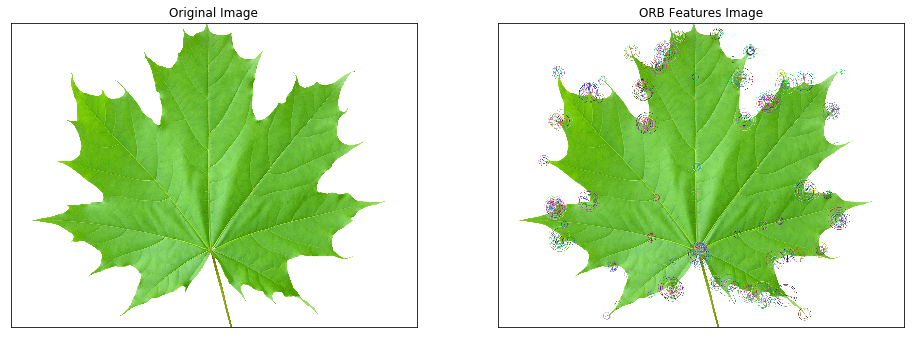

In [31]:
plt.rcParams['figure.figsize']=(16,8)

IMG = os.path.join("../","images","newleaf.jpg")
img = mpimg.imread(IMG)

copy = img.copy()

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(img,None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# draw only keypoints location,not size and orientation
cv2.drawKeypoints(img, kp, copy, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.subplot(121)
plt.title("Original Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.subplot(122)
plt.title("ORB Features Image")
plt.xticks([]), plt.yticks([])
plt.imshow(copy)

plt.show()

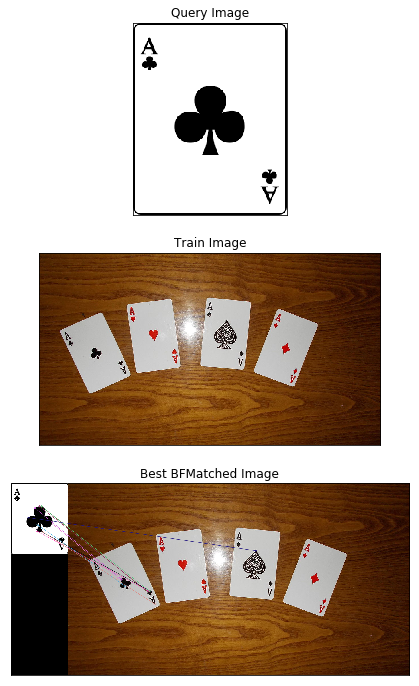

In [11]:
plt.rcParams['figure.figsize']=(16,12)

# query image
IMG   = os.path.join("../","images","card.png")
img1  = cv2.imread(IMG)
img1  = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
copy1 = img1.copy()
copy1 = cv2.cvtColor(copy1, cv2.COLOR_BGR2GRAY)

# train image
IMG2  = os.path.join("../","images","card_in_scene.JPG")
img2  = mpimg.imread(IMG2)
copy2  = img2.copy()
copy2 = cv2.cvtColor(copy2, cv2.COLOR_BGR2GRAY)


# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(copy1,None)
kp2, des2 = orb.detectAndCompute(copy2,None)


# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=2)


plt.subplot(311)
plt.title("Query Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img1)

plt.subplot(312)
plt.title("Train Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img2)

plt.subplot(313)
plt.title("Best BFMatched Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img3)

plt.show()


### Brute-Force Matcher - K-Nearest Match

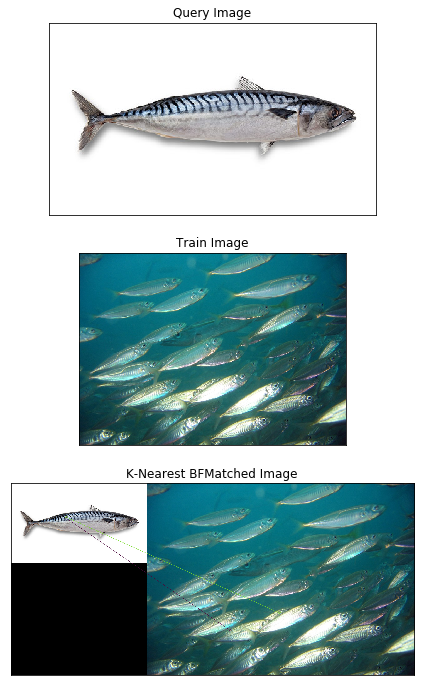

In [21]:
# query image
IMG   = os.path.join("../","images","fish.jpg")
img1  = mpimg.imread(IMG)
copy1 = img1.copy()
copy1 = cv2.cvtColor(copy1, cv2.COLOR_BGR2GRAY)

# train image
IMG2  = os.path.join("../","images","fish_in_scene.jpg")
img2  = mpimg.imread(IMG2)
copy2  = img2.copy()
copy2 = cv2.cvtColor(copy2, cv2.COLOR_BGR2GRAY)

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(copy1,None)
kp2, des2 = orb.detectAndCompute(copy2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)


plt.subplot(311)
plt.title("Query Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img1)

plt.subplot(312)
plt.title("Train Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img2)

plt.subplot(313)
plt.title("K-Nearest BFMatched Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img3)

plt.show()


### Homography - To transfrom between two frames containing the same object

<IPython.core.display.Javascript object>


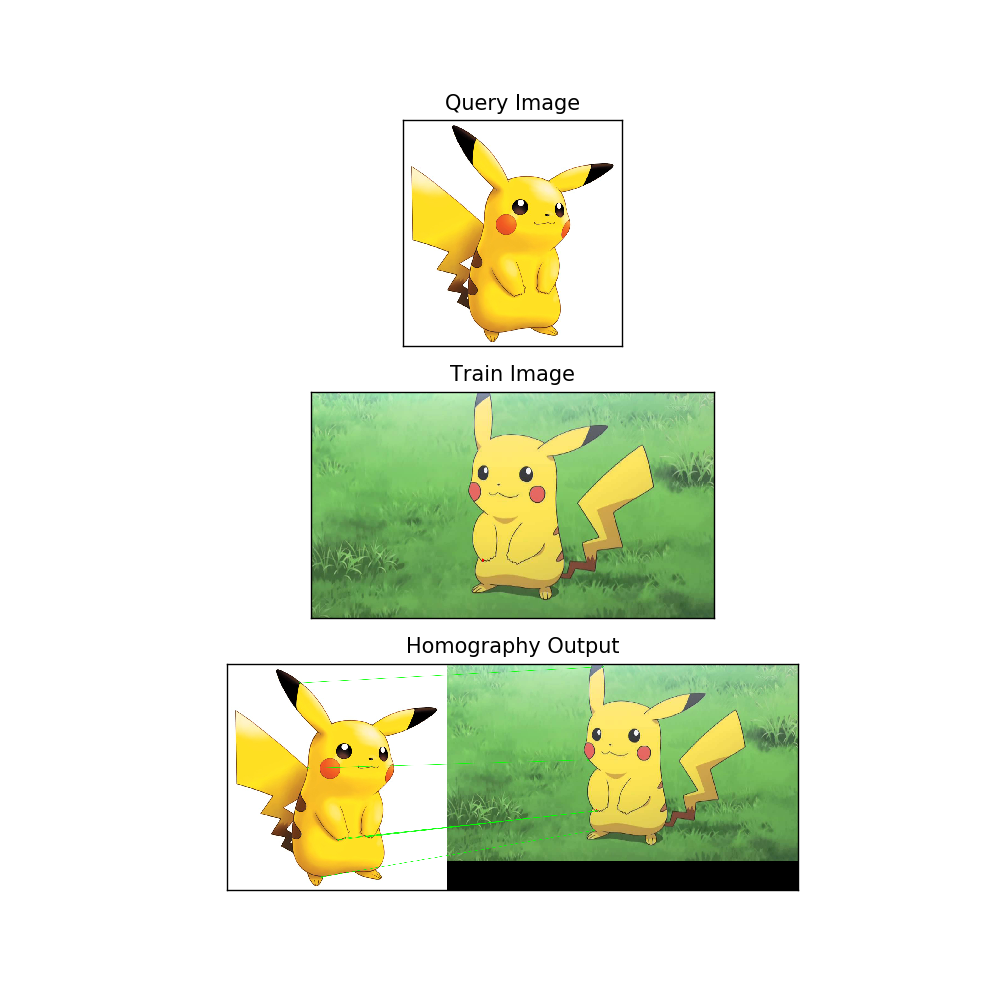

In [90]:
MIN_MATCH_COUNT = 10

# query image
IMG   = os.path.join("../","images","pikachu.png")
img1  = cv2.imread(IMG)
copy1 = img1.copy()
copy1 = cv2.cvtColor(copy1, cv2.COLOR_BGR2GRAY)

# train image
IMG2  = os.path.join("../","images","pikachu_in_scene.jpg")
img2  = mpimg.imread(IMG2)
copy2 = img2.copy()
copy2 = cv2.cvtColor(copy2, cv2.COLOR_BGR2GRAY)


# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0

index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)

search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w,d = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print("Not enough matches are found - {0}/{1}".format(len(good),MIN_MATCH_COUNT))
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.subplot(311)
plt.title("Query Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img1)

plt.subplot(312)
plt.title("Train Image")
plt.xticks([]), plt.yticks([])
plt.imshow(img2)

plt.subplot(313)
plt.title("Homography Output")
plt.xticks([]), plt.yticks([])
plt.imshow(img3)

plt.show()

In [29]:
# MNIST CNN - Loading Data

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


(36, 36)
8


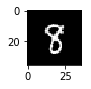

In [107]:
# MNIST Dataset Random Visualization

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

print(image.shape)
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [84]:
# MNIST CNN  -  Building Model

import sys
import time
import tensorflow as tf

EPOCHS = 10
DROPOUT = 0.5
BATCH_SIZE = 100
SCALE = 0.1 # Scaling to 
LEARNING_RATE = 1e-4
FLAGS=None

def deepnn(x):
    """deepnn builds the graph for a deep net for classifying digits.
      Args:
        x: an input tensor with the dimensions (N_examples, 784), where 784 is the
        number of pixels in a standard MNIST image.
      Returns:
        A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
        equal to the logits of classifying the digit into one of 10 classes (the
        digits 0-9). keep_prob is a scalar placeholder for the probability of
        dropout.
    """
    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    x_image = tf.reshape(x, [-1, 28, 28, 1])

    # First convolutional layer - maps one grayscale image to 32 feature maps.
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    # Pooling layer - downsamples by 2X.
    h_pool1 = max_pool_2x2(h_conv1)

    # Second convolutional layer -- maps 32 feature maps to 64.
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    # Second pooling layer.
    h_pool2 = max_pool_2x2(h_conv2)

    # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
    # is down to 7x7x64 feature maps -- maps this to 1024 features.
    W_fc1 = weight_variable([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])

    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Dropout - controls the complexity of the model, prevents co-adaptation of
    # features.
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Map the 1024 features to 10 classes, one for each digit
    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    return y_conv, keep_prob


def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
 
mnist = input_data.read_data_sets("MNIST_data/",  one_hot=True)

# Create the model
x = tf.placeholder(tf.float32, [None, 784])

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

# Build the graph for the deep net
y_conv, keep_prob = deepnn(x)

cross_entropy = tf.reduce_mean(
  tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Training....")
    for epoch in range(EPOCHS):
        # number of batches in one epoch
        batch_count = int(mnist.train.num_examples/BATCH_SIZE)
        for i in range(int(batch_count * SCALE)):
            batch = mnist.train.next_batch(BATCH_SIZE)
            train_accuracy = accuracy.eval(feed_dict={ x: batch[0], y_: batch[1], keep_prob: 1.0})
            train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: DROPOUT})
        print('Epoch %d, training accuracy %g' % (epoch, train_accuracy))
            
    # Testing 
    print('Test accuracy %g' % accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

    # Saving the Model
    save_path = saver.save(sess, "Models/mnist_dnn.ckpt")
    print ("Model saved in file: ", save_path)

    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training....
Epoch 0, training accuracy 0.75
Epoch 1, training accuracy 0.94
Epoch 2, training accuracy 0.92
Epoch 3, training accuracy 0.89
Epoch 4, training accuracy 0.97
Epoch 5, training accuracy 0.93
Epoch 6, training accuracy 0.95
Epoch 7, training accuracy 1
Epoch 8, training accuracy 0.94
Epoch 9, training accuracy 0.96
Test accuracy 0.9617
Model saved in file:  Models/mnist_dnn.ckpt


In [101]:
batch = mnist.train.next_batch(1)
print(batch[0].shape)
print(batch[1].shape)

(1, 784)
(1, 10)


In [109]:
# MNIST CNN  -  Predictor 

"""
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Randomly picking a number
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "Models/mnist_dnn.ckpt")
    print ("Model restored.")
    x = tf.placeholder(tf.float32, [None, 784])
    y_conv, keep_prob = deepnn(x)
    prediction=tf.argmax(y_conv,1)
    res = prediction.eval(feed_dict={x: batch[0],keep_prob: 1.0}, session=sess)
    print(res)
  
plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

""" 


sess = tf.InteractiveSession()

init_op = tf.global_variables_initializer()

saver = tf.train.Saver()

sess.run(init_op)

saver.restore(sess, "Models/mnist_dnn.ckpt")


def predictint(imvalue, y):
    """
    This function returns the predicted integer.
    The input is the pixel values from the imageprepare() function.
    """            
    prediction=tf.argmax(y,1)
    return prediction.eval(feed_dict={x: [imvalue]}, session=sess)

# Test images generation

X_data,Y_label = mnist.train.next_batch(1)

for imvalue, label in zip(X_data,Y_label):
    #imvalue = np.array(image).flatten()
    
    label = predictint(imvalue)
    
    print(label)
    plt.imshow(image)
    plt.show()


INFO:tensorflow:Restoring parameters from Models/mnist_dnn.ckpt


NotFoundError: Key Variable_140 not found in checkpoint
	 [[Node: save_4/RestoreV2_137 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/RestoreV2_137/tensor_names, save_4/RestoreV2_137/shape_and_slices)]]

Caused by op 'save_4/RestoreV2_137', defined at:
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-109-8fd85af6c2b6>", line 34, in <module>
    saver = tf.train.Saver()
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 669, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/rmunshi/.virtualenvs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key Variable_140 not found in checkpoint
	 [[Node: save_4/RestoreV2_137 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save_4/Const_0, save_4/RestoreV2_137/tensor_names, save_4/RestoreV2_137/shape_and_slices)]]


In [65]:
# LeNet - CNN

import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

EPOCHS = 10
BATCH_SIZE = 128

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# Pad images with 0s, since LENET requires 32*32 image
X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

X_train, y_train = shuffle(X_train, y_train)


# Creating Placeholder and one-hot encoding the label data
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)


learning_rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Updated Image Shape: (36, 36, 1)
Training...



ValueError: Cannot feed value of shape (128, 36, 36, 1) for Tensor 'Placeholder_2:0', which has shape '(?, 32, 32, 1)'

In [66]:
# LeNet - CNN - Evaluation
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from None


SystemError: <built-in function TF_Run> returned a result with an error set

In [ ]:
# Inception/ GoogleNet - CNN

